[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/stan/jet/notebooks/DLN_SGLD_trajectory_notebook.ipynb)

# Normal Crossing SGLD trajectory notebook

This notebook uses SGLD to sample from the posterior around a point, for a polynomial model characterized by $y_{pred} = w_1^a * w_2^b * x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned and $x$ is our (1-dimensional) input.

Both the input $x$ and target data $y$ are generated using (independent) gaussian noise, and the loss is Mean Squared Error from $y$ to $y_{pred}$, so the model achieves its lowest loss when $w_1=0$ or $w_2=0$.


In [ ]:
!pip install git+https://github.com/timaeus-research/devinterp.git@stan/jet

%pip install seaborn

fatal: destination path 'devinterp' already exists and is not an empty directory.


/home/svwin/devinterp/notebooks/devinterp
CONTRIBUTING.md  docs  examples        requirements.txt  tests
README.md	 etc   pyproject.toml  src
error: pathspec 'stan/jet' did not match any file(s) known to git
Obtaining file:///home/svwin/devinterp/notebooks/devinterp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for devinterp (pyproject.toml) ... done
  Created wheel for devinterp: filename=devinterp-1.2.0-0.editable-py3-none-any.whl size=3330 sha256=b5ab498cab352bdacd86afebee54ddd0c6065e6f29ca0e8f4a3276194672f25e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ss7slmo0/wheels/b7/08/ce/ef5d797e7c29c36d320d9783a8cf70cd3890f2940f65d80fa4
Successfully built devinterp
  Attempting uninstall: devinterp
    Found existing installation: devinterp 1.2.0
    Uninstalling devinterp-1.2.0:
      Successfully uninstal

In [ ]:
# @title
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib.colors import LinearSegmentedColormap

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import OnlineLLCEstimator
from devinterp.utils import default_nbeta, evaluate_mse
from devinterp.slt.sampler import sample

from devinterp.jet_tools.plot import *
from devinterp.jet_tools.models import *
from devinterp.jet_tools.diffs import *
from devinterp.jet_tools.utils import *

ModuleNotFoundError: No module named 'jet_tools'

# **Auxiliary functions**

In [ ]:
# plotting
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
SEED = 0
SIGMA = 1
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mse

train_loader, train_data, x, y = generate_dataset_for_seed(
    seed=SEED, sigma=SIGMA, batch_size=BATCH_SIZE, num_samples=NUM_TRAIN_SAMPLES
)

## **Marginal and joint distributions of jets**

In [ ]:
test_array = np.array([[[0.0], [1.0], [3.0], [4.0]]])

should_be = np.array([1.0, -1.0])
print(ith_place_nth_diff(test_array, 1, n=2).reshape(-1) - should_be.reshape(-1))

[0. 0.]
[0. 0.]


# **SGLD trajectories sampling**


In [ ]:
method = "xavier"
dln_model = DLN(
    DLNConfig(
        input_dim=2,
        hidden_dim=2,
        output_dim=2,
        n_layers=2,
        initialization_method=method,  # "xavier" "zeros" "random" "kaiming"
    )
)

dln_dataset = create_dataset(dln_model, seed=SEED)
dln_dataloader = torch.utils.data.DataLoader(dln_dataset, batch_size=64)

Created continuous dataset (shuffle parameter is ignored)


In [ ]:
INITIAL_PARAMETERS = [0.0, 0.0]
A_B = [
    1,
    3,
]  # MSE loss function and zero-mean gaussian, so this is effectively w_1**2 * w_2**4 as loss, NB

nbeta = default_nbeta(len(train_data))  # = n/log(n)
model = PolyModel(torch.tensor(A_B).to(DEVICE), DEVICE).to(
    DEVICE
)  # lol idk which one it should be
model.weights = nn.Parameter(
    torch.tensor(INITIAL_PARAMETERS, dtype=torch.float32, requires_grad=True).to(DEVICE)
)

In [ ]:
# Number and length of chains
num_chains_sgld = 1
num_draws_sgld = 10_000

# SGLD parameters
epsilon_sgld = 0.005

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)
sgld_weights = WeightCallback(
    num_chains=num_chains_sgld, num_draws=num_draws_sgld, model=dln_model
)

online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgld,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)
trace_sgld = sample(
    dln_model,
    dln_dataloader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(lr=epsilon_sgld, nbeta=nbeta, bounding_box_size=1.0),
    sampling_method=SGLD,
    num_chains=num_chains_sgld,  # independent sampling runs
    num_draws=num_draws_sgld,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgld_weights],
    seed=SEED,
)

/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:225: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:264: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/devinterp/backends/default/slt/sampler.py:291: UserWarning: You are using seeded runs, for full reproducibility check https://pytorch.org/docs/stable/notes/randomness.html
  warnings.warn(
Chain 0:  88%|████████▊ | 8827/10000 [01:28<00:09, 120.99it/s]

In [ ]:
wt_sgld = np.array(sgld_weights.get_results()["ws/trace"])

# numpy running mean of llc_chain (does not work yet with multiple chains)
llc_chain = online_llc_estimator.get_results()["llc/trace"]
# llc_chain = np.cumsum(llc_chain) / np.arange(1, len(llc_chain[0]) + 1)
print(np.nonzero(np.isnan(wt_sgld)))
print(epsilon_sgld * num_draws_sgld)

# take the first element of the first element of every weights tensor (which has shape (3, 10000, 2, 3, 3)), so we get
# wt_sgld = wt_sgld[:,:,:,0,0]
# print(wt_sgld.shape)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
50.0


# **SGLD plots**

## **Plotting SGLD trajectories and jet coordinates**

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

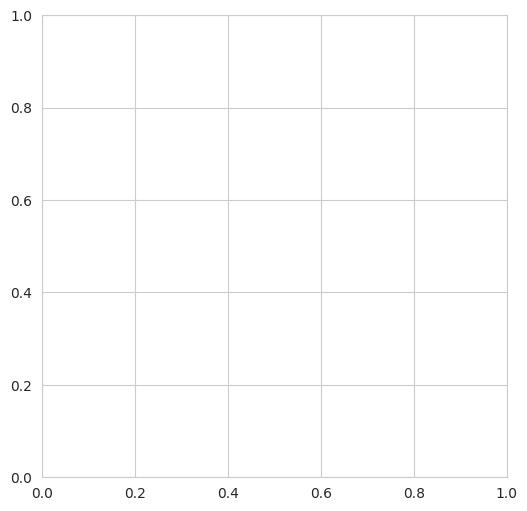

In [ ]:
plot_multi_trajectories(wt_sgld, [1, 10], [0, 1, 2], "SLGD")

## **Plot cumulant statistics of marginal distribution of jet coordinates SGLD**


(1, 10000, 8)


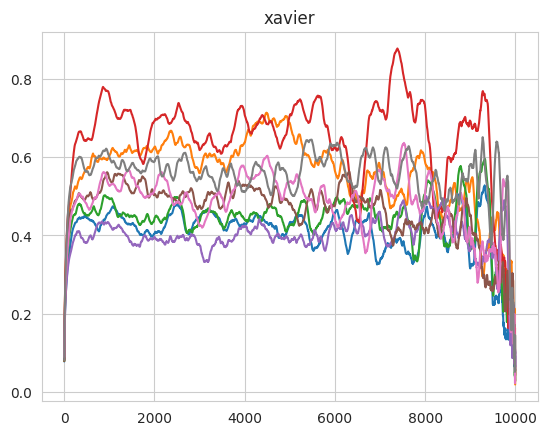

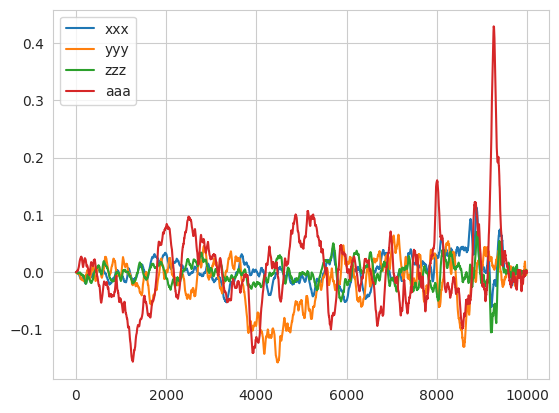

In [ ]:
flattened = wt_sgld.reshape((num_chains_sgld, num_draws_sgld, -1))
print(flattened.shape)
plot_second_order_first_place_stats(flattened, 1, method=method)
plot_third_order_stats_per_dim(flattened, 1, method=method)

ValueError: x and y can be no greater than 2D, but have shapes (9997,) and (9997, 2, 2)

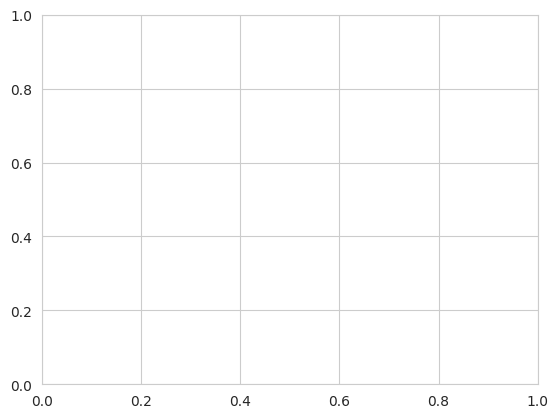

In [ ]:
plot_second_order_two_place_stats(wt_sgld, 1)

In [ ]:
plot_third_order_stats(wt_sgld, 1)

## **Vector fields SGLD**

In [ ]:
plot_vector_field_jets(wt_sgld, [10, 100, 500], [1], 15, "SGLD")

# **SGHNT trajectories sampling**

In [ ]:
num_chains_sgnht = 1
num_draws_sgnht = 10_000

epsilon_sgnht = 0.001

In [ ]:
sgnht_weights = WeightCallback(
    num_chains=num_chains_sgnht, num_draws=num_draws_sgnht, model=model
)
online_llc_estimator = OnlineLLCEstimator(
    num_chains=num_chains_sgnht,
    num_draws=num_draws_sgld,
    nbeta=nbeta,
    init_loss=0.0,
    device=DEVICE,
)

trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=epsilon_sgnht, nbeta=nbeta, diffusion_factor=0.005, bounding_box_size=1.0
    ),
    sampling_method=SGNHT,
    num_chains=num_chains_sgnht,  # independent sampling runs
    num_draws=num_draws_sgnht,  # length of a sampling run
    verbose=True,
    device=DEVICE,
    callbacks=[online_llc_estimator, sgnht_weights],
    seed=SEED,
)

In [ ]:
wt_sgnht = np.array(sgnht_weights.get_results()["ws/trace"])

print(np.nonzero(np.isnan(wt_sgnht)))
print(epsilon_sgld * num_draws_sgnht)

# **SGNHT plots**

## **Plotting SGNHT trajectories and jet coordinates**




In [ ]:
plot_multi_trajectories(wt_sgnht, [1, 10], [0, 1, 2], "SGNHT")

## **Plot cumulant statistics of marginal distribution of jet coordinates SGNHT**

In [ ]:
plot_second_order_two_place_stats(wt_sgnht, 1)

In [ ]:
plot_third_order_stats(wt_sgnht, 1)

## **Vector fields SGNHT**

In [ ]:
plot_vector_field_jets(wt_sgnht, [10, 100, 500], [1], 15, "SGNHT")